In [1]:
import os
import torch
from torch import nn
from poutyne import Model, CSVLogger
from poutyne.framework import ModelCheckpoint, EarlyStopping, plot_history
import numpy as np
import torchmetrics
from datetime import datetime
import sys
import pandas as pd
from custom_lib.custom_models.basic_nn import NeuralNetwork
from custom_lib.data_prep import data_transformation_pipeline, data_loader
import matplotlib as plt
import torchvision.models as models
import time


In [2]:
# These need to be passed in a parse args statement
# Tuneable Params
lr = 1e-3
data_dir = "data_3_class"
model_name = "b0"
save_logs = True
epochs = 40
rotate_angle=None
horizontal_flip_prob=None
brightess_contrast=None
gaussian_blur=5
normalize=True
seed = 42
batch_size = 32
results_folder_name = "test_3"
truncated_layers = 1
bootstrap_n = 5
pretrained = True


In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using mps device


In [4]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import EfficientNet_B0_Weights, EfficientNet_B1_Weights, EfficientNet_B2_Weights, EfficientNet_B3_Weights

# Define the model mapping as a constant (outside the function)
MODEL_MAPPING = {
    "b0": ("efficientnet_b0", EfficientNet_B0_Weights.IMAGENET1K_V1),
    "b1": ("efficientnet_b1", EfficientNet_B1_Weights.IMAGENET1K_V1),
    "b2": ("efficientnet_b2", EfficientNet_B2_Weights.IMAGENET1K_V1),
    "b3": ("efficientnet_b3", EfficientNet_B3_Weights.IMAGENET1K_V1),
}

def load_efficientnet(model_name, model_mapping, pretrained):
    """
    Load an EfficientNet model based on the provided model name and model mapping.

    Args:
        model_name (str): The name of the EfficientNet model (e.g., "b0", "b1", "b2", "b3").
        model_mapping (dict): A dictionary mapping model names to their corresponding classes and weights.

    Returns:
        torch.nn.Module: The loaded EfficientNet model.

    Raises:
        ValueError: If the model name is not supported.
    """
    # Check if the model name is valid
    if model_name not in model_mapping:
        raise ValueError(f"Unsupported model name: {model_name}. Supported models are: {list(model_mapping.keys())}")

    # Get the model class and weights from the mapping
    model_class_name, weights = model_mapping[model_name]
    model_class = getattr(models, model_class_name)

    if pretrained:
        # Load the model with pretrained weights
        effnet = model_class(weights=weights)
    else:
        effnet = model_class(weights=None)
    return effnet


try:
    effnet = load_efficientnet(model_name, MODEL_MAPPING, pretrained=pretrained)
    print(f"Successfully loaded EfficientNet {model_name}.")
except ValueError as e:
    print(e)

Successfully loaded EfficientNet b0.


In [5]:
if model_name == "b0":
    image_size = 224
if model_name == "b1":
    image_size = 240
if model_name == "b2":
    image_size = 260
if model_name == "b3":
    image_size = 300

In [6]:
train_transform = data_transformation_pipeline(image_size = image_size,
                                               rotate_angle=rotate_angle,
                                               horizontal_flip_prob=horizontal_flip_prob,
                                               gaussian_blur=gaussian_blur,
                                               normalize=normalize,
                                               is_train=True)
test_transform = data_transformation_pipeline(image_size = image_size,
                                               rotate_angle=rotate_angle,
                                               horizontal_flip_prob=horizontal_flip_prob,
                                               gaussian_blur=gaussian_blur,
                                               normalize=normalize,
                                               is_train=False)
val_transform = data_transformation_pipeline(image_size = image_size,
                                               rotate_angle=rotate_angle,
                                               horizontal_flip_prob=horizontal_flip_prob,
                                               gaussian_blur=gaussian_blur,
                                               normalize=normalize,
                                               is_train=False)

train_loader , val_loader, test_loader, num_classes = data_loader(data_dir, 
                                                     train_transform=train_transform,
                                                     test_transform=test_transform,
                                                     val_transform=val_transform,
                                                     seed=seed,
                                                     batch_size=batch_size
                                                     )


Train size: 4182, Validation size: 522, Test size: 524


In [7]:


class TruncatedEffNet(nn.Module):
    def __init__(self, effnet, num_classes, removed_layers, batch_size, image_size):
        super(TruncatedEffNet, self).__init__()

        # Truncate the EfficientNet backbone
        layers = 7 - removed_layers
        self.effnet_truncated = nn.Sequential(*list(effnet.features.children())[:layers])

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Dynamically calculate the input size for the fully connected layer
        with torch.no_grad():  # Disable gradient tracking for this forward pass
            dummy_input = torch.randn(batch_size, 3, image_size, image_size)  # Example input (batch_size=1, channels=3, height=224, width=224)
            dummy_output = self.effnet_truncated(dummy_input)
            dummy_output = self.global_avg_pool(dummy_output)
            fc_input_size = dummy_output.view(dummy_output.size(0), -1).size(1)  # Flatten and get the size

        self.classifier = nn.Sequential(
            nn.Dropout(.2),
            nn.Linear(fc_input_size, num_classes)
        )

        self.fc_lrelu = nn.Sequential(
                    nn.Linear(fc_input_size, 256),
                    nn.LeakyReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(256, 128),
                    nn.Linear(128, num_classes)
                    )   
        # Define the fully connected layer
        self.fc = nn.Linear(fc_input_size, num_classes)

    def forward(self, x):
        x = self.effnet_truncated(x)  # Extract features
        x = self.global_avg_pool(x)  # Pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = self.classifier(x)  # Classification
        # x = self.fc_lrelu(x)
        return x

# Instantiate the model with the truncated backbone
model = TruncatedEffNet(effnet, num_classes, removed_layers=truncated_layers, batch_size=batch_size, image_size=image_size)

In [8]:
# from efficientnet_pytorch import EfficientNet


# # Load the pre-trained EfficientNet-B0 model
# # model = EfficientNet.from_pretrained('efficientnet-b0')
# model = effnet

# # Modify the last layer to match the number of classes in your dataset
# model._fc = torch.nn.Linear(model._fc.in_features, num_classes)

In [9]:
if save_logs:
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")

    # Create directory for saving all logs and model outputs 
    results_dir = os.path.join(f"{results_folder_name}/{model_name}_reduced_layers_{truncated_layers}_{timestamp}")
    os.makedirs(results_dir, exist_ok=True)
    print(f"Logs and output will be saved in: {results_dir}")


Logs and output will be saved in: test_3/b0_reduced_layers_1_2025-02-21_12-57


In [10]:
from torch.optim.lr_scheduler import ReduceLROnPlateau




# 6. Wrap the model with Poutyne
poutyne_model = Model(
    model,
    # optimizer=torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9),  # Added momentum

    optimizer=torch.optim.Adamax(model.parameters(), lr=lr),
    loss_function=nn.CrossEntropyLoss(),
    batch_metrics=["accuracy"],
    device=device
)

In [11]:
from poutyne import ReduceLROnPlateau, Callback

# Add the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.1,          # Reduce LR by a factor of 0.1
    patience=5,          # Wait 5 epochs before reducing LR
    verbose=True         # Print a message when LR is reduced
)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10)

class PrintLRSchedulerCallback(Callback):
    def set_model(self, model):
        self.model = model  # Store the model reference

    def on_epoch_end(self, epoch, logs):
        lr = self.model.optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch + 1}: Current LR = {lr}")

# Instantiate the callback
print_lr_callback = PrintLRSchedulerCallback()

# Add it to the list of callbacks
# callbacks = [reduce_lr, early_stopping, print_lr_callback]
callbacks = [reduce_lr, print_lr_callback]

if save_logs == True:
    # Callback: Save the best model based on validation accuracy
    checkpoint = ModelCheckpoint(f"{results_dir}/best_model.pth", monitor='val_loss', mode='min', save_best_only=True)
    csv_logger = CSVLogger(f"{results_dir}/training_logs.csv")
    callbacks = [checkpoint, csv_logger, reduce_lr, print_lr_callback]
    

start_time = time.time()
# 7. Train the model
history = poutyne_model.fit_generator(train_loader, val_loader, epochs=epochs, verbose=True,
                            callbacks = callbacks)
end_time = time.time()

run_time = end_time - start_time

print(f"Model training took {run_time / 60} minutes")

if save_logs:
    # Save the final model manually
    torch.save(poutyne_model.network.state_dict(), f"{results_dir}/final_model.pth")

/Users/ayw1327/Documents/GitHub/cxr_thesis/myenv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch:  1/40 Train steps: 131 Val steps: 9 1m21.65s loss: 0.130785 acc: 95.600191 val_loss: 0.071326 val_acc: 97.318008
Epoch 2: Current LR = 0.001
Epoch:  2/40 Train steps: 131 Val steps: 9 1m18.76s loss: 0.062828 acc: 97.895744 val_loss: 0.071311 val_acc: 97.509579
Epoch 3: Current LR = 0.001
Epoch:  3/40 Step: 9/9 100.00% |████████████████████|ETA: 0.00s val_loss: 0.002241 val_acc: 100.000000

In [13]:
if save_logs:
    best_model_path = f"{results_dir}/best_model.pth"
    
    # Load the state dict into the model
    poutyne_model.network.load_state_dict(torch.load(best_model_path))


/var/folders/gw/q9_8w8jn0js6k5m5d98vhhcdzkx593/T/ipykernel_19184/2789483476.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  poutyne_model.network.load_state_dict(torch.l

In [14]:
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Subset
from poutyne import Model
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

def bootstrap_evaluation_poutyne(model, test_loader, save_logs, results_dir, n_bootstraps=1000, seed=42):
    """
    Perform bootstrap evaluation of a model on a test dataset.

    Args:
        model: The trained Poutyne model to evaluate.
        test_loader: DataLoader for the test dataset.
        save_logs: Whether to save the metric distributions to CSV.
        results_dir: Directory to save the bootstrap distribution CSV.
        n_bootstraps: Number of bootstrap samples to generate.
        seed: Random seed for reproducibility.

    Returns:
        A pandas DataFrame with mean and confidence intervals for:
        - Accuracy
        - F1 Score
        - Sensitivity (Recall)
        - Specificity
        - Test Loss
    """
    rng = np.random.RandomState(seed)

    # Store bootstrapped metrics
    metrics = {
        "accuracy": [],
        "f1_score": [],
        "sensitivity": [],
        "specificity": [],
        "loss": [],
    }

    for _ in range(n_bootstraps):
        sampled_indices = rng.choice(len(test_loader.dataset), len(test_loader.dataset), replace=True)
        sampled_subset = Subset(test_loader.dataset, sampled_indices)
        sampled_loader = DataLoader(sampled_subset, batch_size=test_loader.batch_size, shuffle=False)

        # Evaluate using Poutyne
        test_loss, test_acc = model.evaluate_generator(sampled_loader)

        # Extract predictions and true labels
        y_true, y_pred = [], []
        for inputs, labels in sampled_loader:
            outputs = model.predict_on_batch(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(np.argmax(outputs, axis=1))

        # Compute metrics
        f1 = f1_score(y_true, y_pred, average='macro')
        sensitivity = recall_score(y_true, y_pred, average='macro')

        # Compute specificity
        cm = confusion_matrix(y_true, y_pred)
        specificity_values = []
        for i in range(cm.shape[0]):
            col_sum = cm[:, i].sum()
            if col_sum > 0:
                specificity_values.append(cm[i, i] / col_sum)
        specificity = np.mean(specificity_values) if specificity_values else 0.0

        # Store results
        metrics["accuracy"].append(test_acc)
        metrics["f1_score"].append(f1)
        metrics["sensitivity"].append(sensitivity)
        metrics["specificity"].append(specificity)
        metrics["loss"].append(test_loss)

    if save_logs:
        # Save the full bootstrap distributions
        dist_df = pd.DataFrame(metrics)
        dist_df.to_csv(f"{results_dir}/bootstrap_distribution.csv", index=False)

    # Compute mean and confidence intervals
    def compute_ci(values):
        return np.mean(values), np.percentile(values, 2.5), np.percentile(values, 97.5)

    results_dict = {f"{metric}_{stat}": value
                    for metric, values in metrics.items()
                    for stat, value in zip(["mean", "low", "high"], compute_ci(values))}

    # Convert to DataFrame
    results_df = pd.DataFrame([results_dict])

    return results_df


In [15]:
from thop import profile

# Create a dummy input tensor with the same shape as your model's input
dummy_input = torch.randn(batch_size, 3, image_size, image_size).to(device)  # Batch size = 1, Channels = 3, Height = image_size, Width = image_size

# Compute FLOPs and parameters
flops, params = profile(model, inputs=(dummy_input,))

gflops = flops / 1000000000

print(f"GFLOPs: {gflops}")
print(f"Parameters: {params}")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_normalization() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_relu() for <class 'torch.nn.modules.activation.LeakyReLU'>.
GFLOPs: 11.8640816
Parameters: 2960847.0


/Users/ayw1327/Documents/GitHub/cxr_thesis/myenv/lib/python3.11/site-packages/poutyne/plotting.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


((<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>),
 (<Axes: title={'center': 'b0 Training'}, xlabel='Epochs', ylabel='Loss'>,
  <Axes: title={'center': 'b0 Training'}, xlabel='Epochs', ylabel='Accuracy'>))

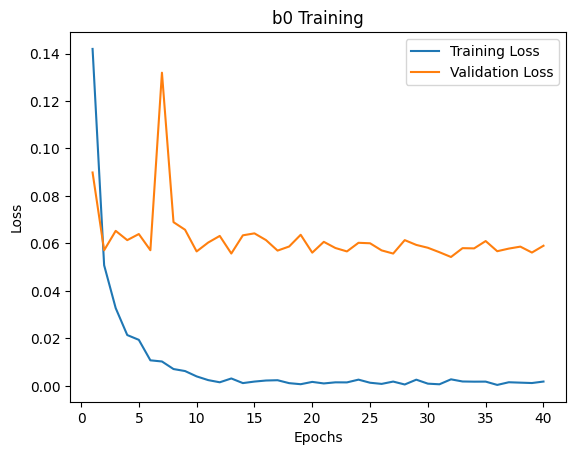

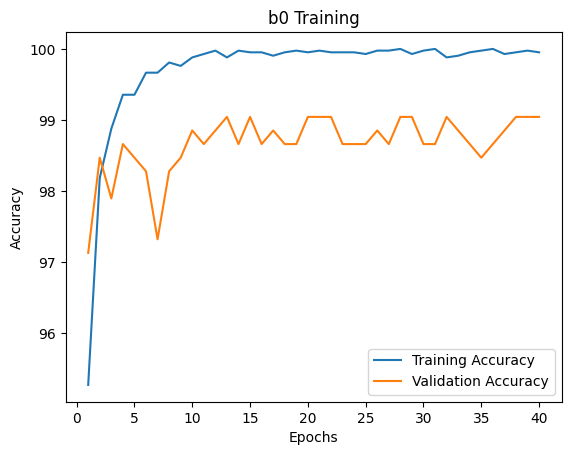

In [16]:
plot_history(
        history,
        metrics=['loss', 'acc'],
        labels=['Loss', 'Accuracy'],
        titles=f"{model_name} Training",

    )

In [17]:

# # Run bootstrapping evaluation with your Poutyne model
boot_strap_results = bootstrap_evaluation_poutyne(poutyne_model, test_loader, n_bootstraps = bootstrap_n, save_logs=save_logs, results_dir=results_dir)


Test steps: 11 2.34s test_loss: 0.006195 test_acc: 99.618321                                 
Test steps: 11 1.53s test_loss: 0.053411 test_acc: 98.473282                                 
Test steps: 11 1.47s test_loss: 0.027217 test_acc: 99.236641                                 
Test steps: 11 1.51s test_loss: 0.065450 test_acc: 97.709924                                 
Test steps: 11 1.46s test_loss: 0.058295 test_acc: 98.282443                                 


In [18]:
boot_strap_results

,accuracy_mean,accuracy_low,accuracy_high,f1_score_mean,f1_score_low,f1_score_high,sensitivity_mean,sensitivity_low,sensitivity_high,specificity_mean,specificity_low,specificity_high,loss_mean,loss_low,loss_high
0,98.664122,97.767176,99.580153,0.986859,0.978075,0.995889,0.987013,0.978625,0.995938,0.986791,0.977801,0.995845,0.042114,0.008297,0.064735


/Users/ayw1327/Documents/GitHub/cxr_thesis/myenv/lib/python3.11/site-packages/poutyne/plotting.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


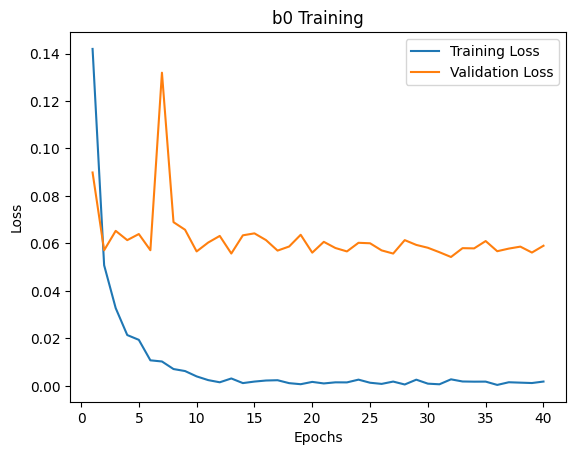

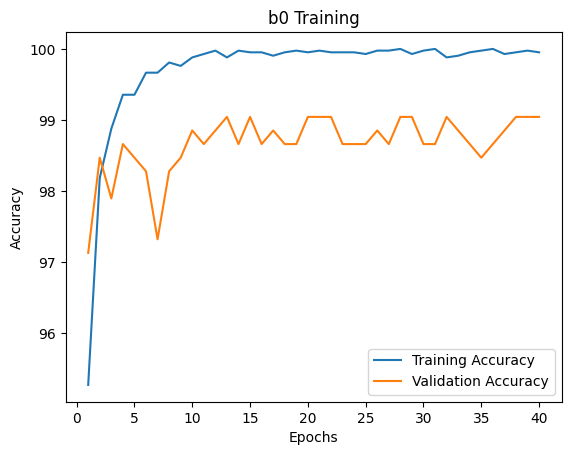

In [19]:
# Save logs and plots
if save_logs:
    with open(f"{results_dir}/model_overview.txt", "w") as file:
        file.write(f"Model Structure:\n{model}\n")
        file.write(f"Using {device} device\n")

# Check if CSV exists
    if os.path.exists(f"{results_folder_name}/test_results.csv"):
        test_results_df = pd.read_csv(f"{results_folder_name}/test_results.csv")
    else:
        test_results_df = pd.DataFrame(columns=[
            "model_id", "model", "epochs", "run_time", "lr", "image_size",
            "rotate_angle", "horizontal_flip_prob", "gaussian_blur", "normalize", "seed", "truncated_layers"
        ])

    # Create a DataFrame for the new model's metadata
    new_results_df = pd.DataFrame({
        "model_id": [f"{model_name}_reduced_layers_{truncated_layers}_{timestamp}"],
        "model": [model_name],
        "truncated_layers": [truncated_layers],
        "epochs": [epochs],  
        "run_time": [run_time / 60],  
        "lr": [lr],
        "image_size": [image_size],  
        "rotate_angle": [rotate_angle],  
        "horizontal_flip_prob": [horizontal_flip_prob],  
        "gaussian_blur": [gaussian_blur],  
        "normalize": [normalize],
        "seed": [seed],
        "gflops": [gflops],
        "params": [params]
    })

    # Combine test metadata with bootstrapped results (column-wise merge)
    new_results_df = pd.concat([new_results_df, boot_strap_results], axis=1)

    # Append to existing DataFrame
    test_results_df = pd.concat([test_results_df, new_results_df], ignore_index=True)

    # Save updated results
    test_results_df.to_csv(f"{results_folder_name}/test_results.csv", index=False)

    # Plot training history
    plot_history(
        history,
        metrics=['loss', 'acc'],
        labels=['Loss', 'Accuracy'],
        titles=f"{model_name} Training",
        save=True,  
        save_filename_template='{metric}_plot',  
        save_directory=results_dir,  
        save_extensions=('png',)  
    )
